In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pandas.tseries.offsets import MonthBegin
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})

In [2]:
df_agg = pd.read_pickle('/Users/mwirvine/Galvanize/dsi-immersive/Capstone-Equipment-Rental-Data/df_agg.pkl')

In [4]:
df_company_rev = df_agg.groupby(['month']).agg({'rental_revenue':'sum', 'units_rented':'sum'}).reset_index()

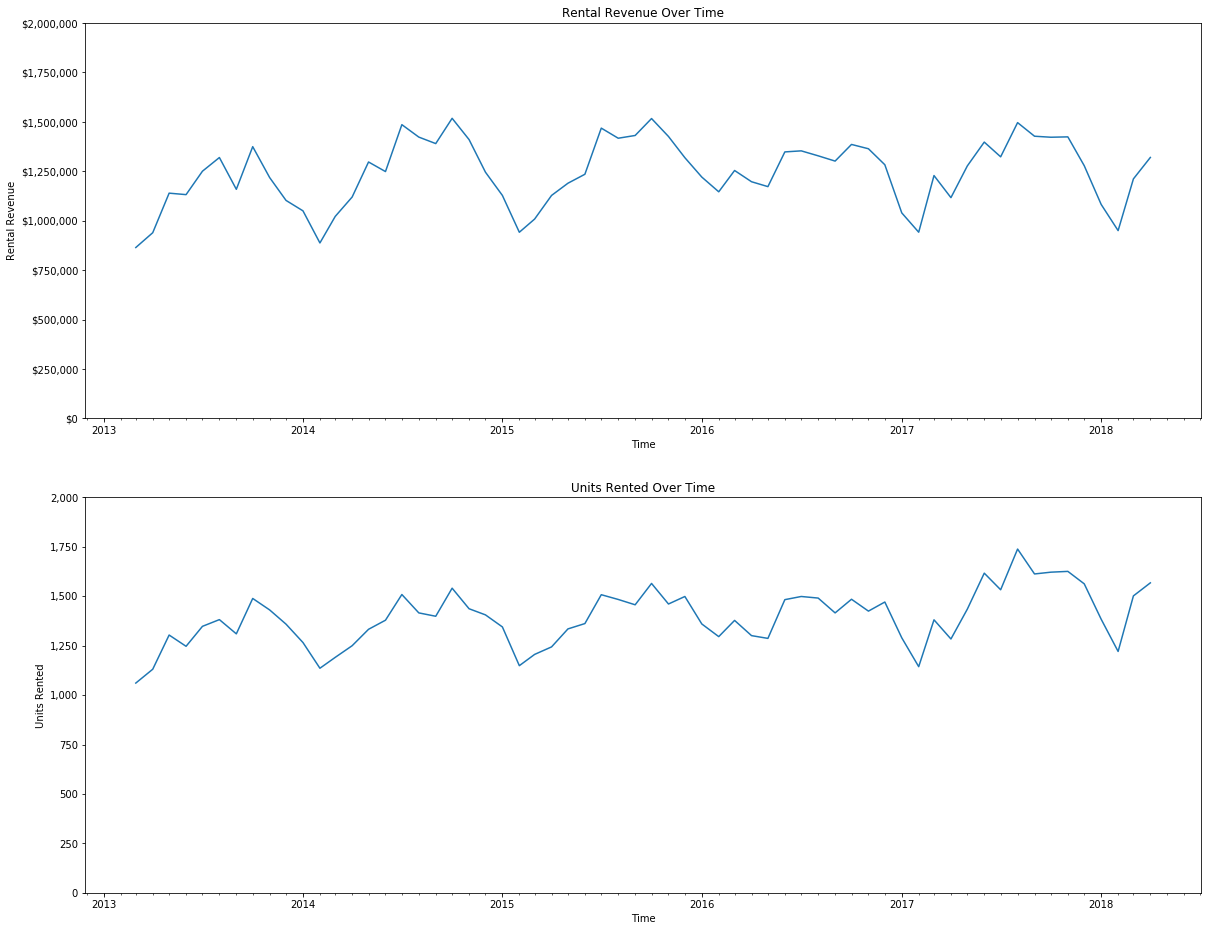

In [6]:
fig1 = plt.figure(figsize = (20,16))
ax1 = fig1.add_subplot(211)
ax1.plot(df_company_rev['month'], df_company_rev['rental_revenue'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Rental Revenue')
ax1.set_title('Rental Revenue Over Time')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick)
ax1.set_yticks([0, 2000000], True)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)

ax2 = fig1.add_subplot(212)
ax2.plot(df_company_rev['month'], df_company_rev['units_rented'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Units Rented')
ax2.set_title('Units Rented Over Time')

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax2.yaxis.set_major_formatter(tick)
ax2.set_yticks([0, 2000], True)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)
plt.savefig('../imgs/rev_units_time.png');

In [7]:
df_orig = pd.read_csv('/Users/mwirvine/Galvanize/dsi-immersive/one-source-capstone/Data Feeds/ONE - Revenue Data.txt', sep='|')

/Users/mwirvine/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_orig = df_orig.loc[df_orig['Client Category'] == 20, :]
df_cat_20 = df_orig.groupby(['Client Product Type']).agg({'Rental Revenue':'sum'}).reset_index()
df_cat_20 = df_cat_20.sort_values('Rental Revenue')

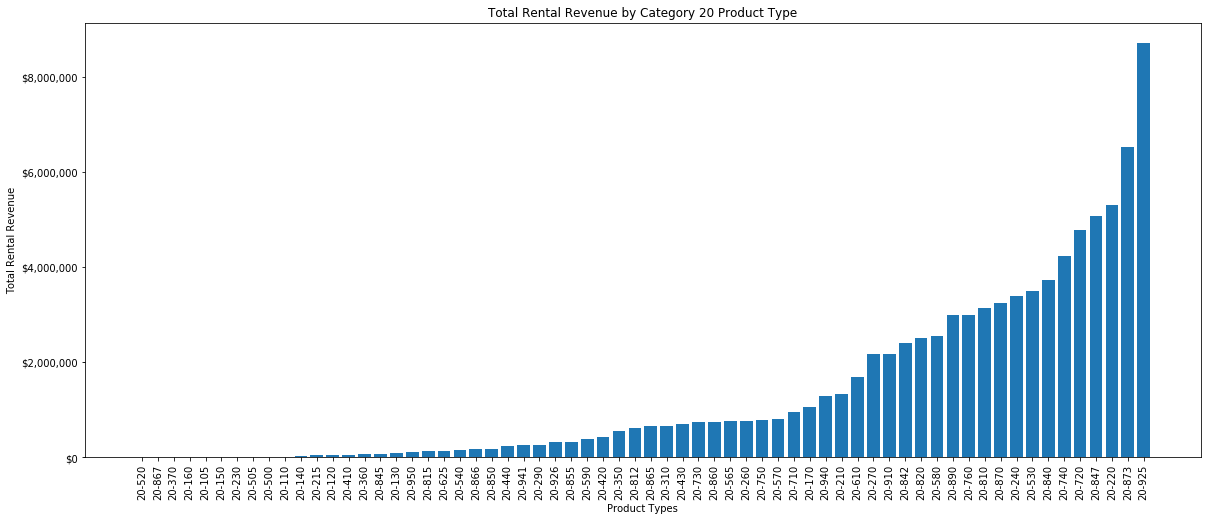

In [9]:
fig1 = plt.figure(figsize = (20,8))
ax1 = fig1.add_subplot(111)
ax1.bar(df_cat_20['Client Product Type'], df_cat_20['Rental Revenue'])
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick)
ax1.set_yticks([0, 2000000], True)
plt.xticks(rotation=90)
ax1.set_xlabel('Product Types')
ax1.set_ylabel('Total Rental Revenue')
ax1.set_title('Total Rental Revenue by Category 20 Product Type')
plt.savefig('../imgs/cat_20_rev.png');

In [13]:
df_agg_test = df_agg.loc[df_agg['month'] >= '2017-05-01', :]
df_agg_train = df_agg.loc[df_agg['month'] < '2017-05-01', :]

In [15]:
corr_matrix = df_agg_train.drop(['month', 'rental_revenue', 'total_days_rented', 'avg_price_per_day'], axis=1).corr()
corr_matrix['units_rented'].sort_values(ascending=False)

units_rented                     1.000000
same_month_avg_units_rented      0.982760
prior_month_units_rented         0.973047
same_month_avg_days_rented       0.935381
prior_month_total_days_rented    0.933153
product_type_20-220              0.604499
prior_month_rental_revenue       0.500430
rental_type_monthly              0.359297
product_type_20-240              0.237227
product_type_20-720              0.114928
product_type_20-210              0.064286
product_type_20-270              0.062767
product_type_20-530              0.046346
invoice_start_month_10           0.017360
invoice_start_month_7            0.013088
invoice_start_month_12           0.011312
invoice_start_month_11           0.009724
product_type_20-810              0.009104
product_type_20-740              0.008835
product_type_20-847              0.008621
product_type_20-840              0.007816
product_type_20-170              0.007752
invoice_start_month_8            0.007037
invoice_start_month_1            0

In [16]:
features = ['units_rented', 'prior_month_units_rented', 'prior_month_total_days_rented', 'same_month_avg_units_rented', 'same_month_avg_days_rented', 'prior_month_rental_revenue']

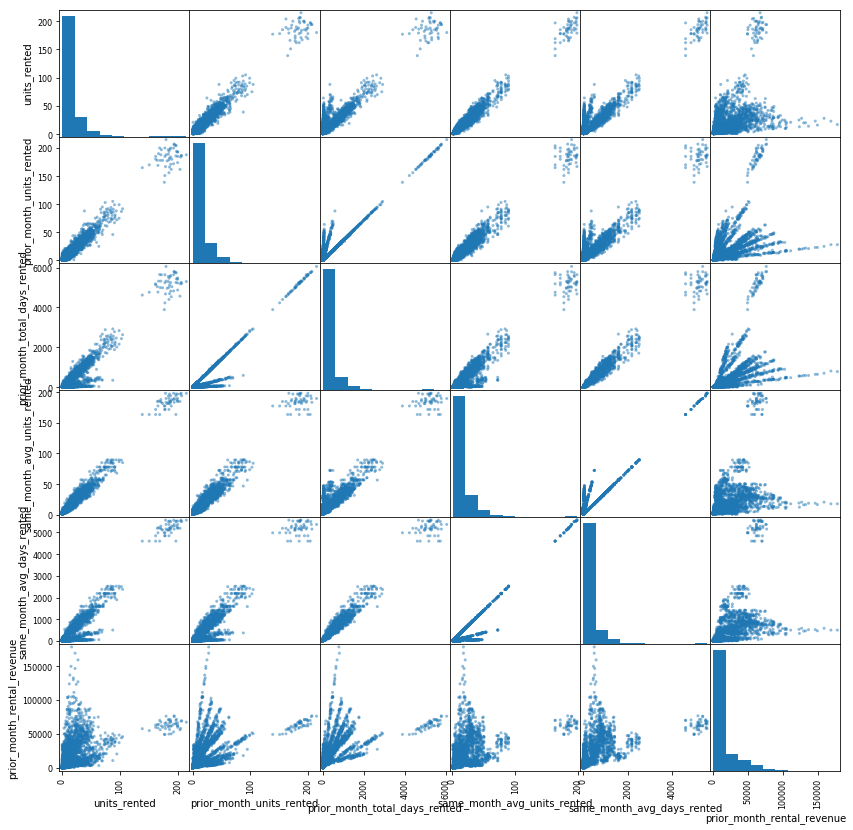

In [17]:
scatter_matrix(df_agg_train[features], figsize=(14,14));

In [18]:
X_train = df_agg_train.drop(['units_rented', 'month', 'rental_revenue', 'total_days_rented', 'avg_price_per_day'], axis=1).values
y_train = df_agg_train['units_rented'].values
X_test = df_agg_test.drop(['units_rented', 'month', 'rental_revenue', 'total_days_rented', 'avg_price_per_day'], axis=1).values
y_test = df_agg_test['units_rented'].values
standardizer = StandardScaler()
standardizer.fit(X_train, y_train)
X_train_std = standardizer.transform(X_train)
X_test_std = standardizer.transform(X_test)

In [19]:
X_train_std_wconst = sm.add_constant(X_train_std)
ols = sm.OLS(y_train, X_train_std_wconst).fit()
ols_res = ols.outlier_test()[:,0]
y_fitted = ols.fittedvalues

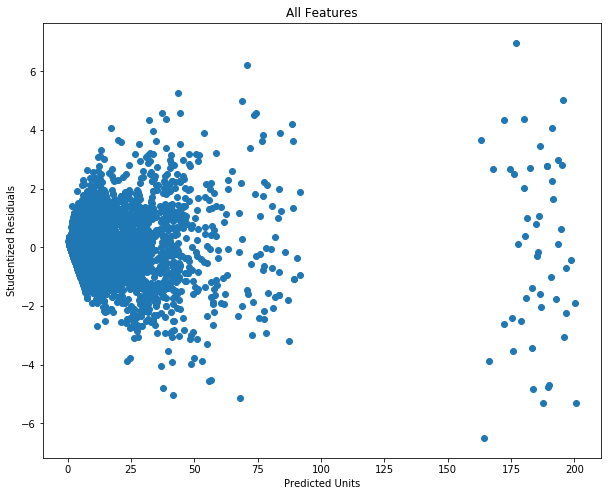

In [21]:
fig1 = plt.figure(figsize = (10,8))
ax1 = fig1.add_subplot(111)
ax1.scatter(y_fitted, ols_res)
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Studentized Residuals')
ax1.set_title('All Features');

In [22]:
## Linear Regression
linear = LinearRegression(n_jobs=-1)
linear.fit(X_train_std, y_train)
y_pred_train_linear = linear.predict(X_train_std)
y_pred_test_linear = linear.predict(X_test_std)

In [23]:
## Random Forest
rf = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, min_samples_leaf=4, min_samples_split=8)
rf.fit(X_train_std, y_train)
y_pred_train_rf = rf.predict(X_train_std)
y_pred_test_rf = rf.predict(X_test_std)

In [24]:
df_agg_test = pd.read_pickle('/Users/mwirvine/Galvanize/dsi-immersive/Capstone-Equipment-Rental-Data/df_agg_test.pkl')

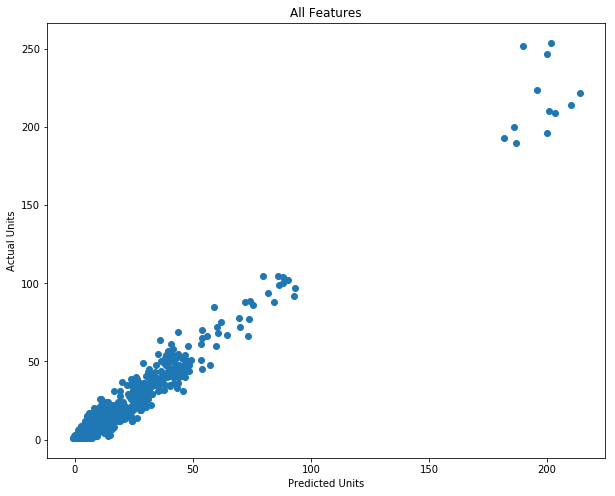

In [27]:
fig2 = plt.figure(figsize = (10,8))
ax1 = fig2.add_subplot(111)
ax1.scatter(df_agg_test['units_rented_pred_Linear'], df_agg_test['units_rented'])
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Actual Units')
ax1.set_title('All Features');

In [29]:
df_company_units = df_agg_test.groupby(['month', 'rental_type_daily', 'rental_type_weekly', 'rental_type_monthly']).agg({'rental_revenue':'sum', 'same_month_avg_units_rented':'sum', 'units_rented':'sum', 'units_rented_pred_Linear':'sum', 'units_rented_pred_Random Forest':'sum'}).reset_index()
df_company_units_monthly = df_company_units.loc[df_company_units['rental_type_monthly'] == 1, :]
df_company_units_weekly = df_company_units.loc[df_company_units['rental_type_weekly'] == 1, :]
df_company_units_daily = df_company_units.loc[df_company_units['rental_type_daily'] == 1, :]
df_company_units.head()

,month,rental_type_daily,rental_type_weekly,rental_type_monthly,rental_revenue,same_month_avg_units_rented,units_rented,units_rented_pred_Linear,units_rented_pred_Random Forest
0,2017-05-01,0,0,1,917817.0,805.000000,841,803.095250,797.277535
1,2017-05-01,0,1,0,223258.0,253.750000,275,258.702697,259.517772
2,2017-05-01,1,0,0,136066.0,259.083333,319,269.613373,264.891327
3,2017-06-01,0,0,1,990166.0,823.750000,949,836.971363,837.446903
4,2017-06-01,0,1,0,251980.0,257.416667,294,268.517605,273.007112


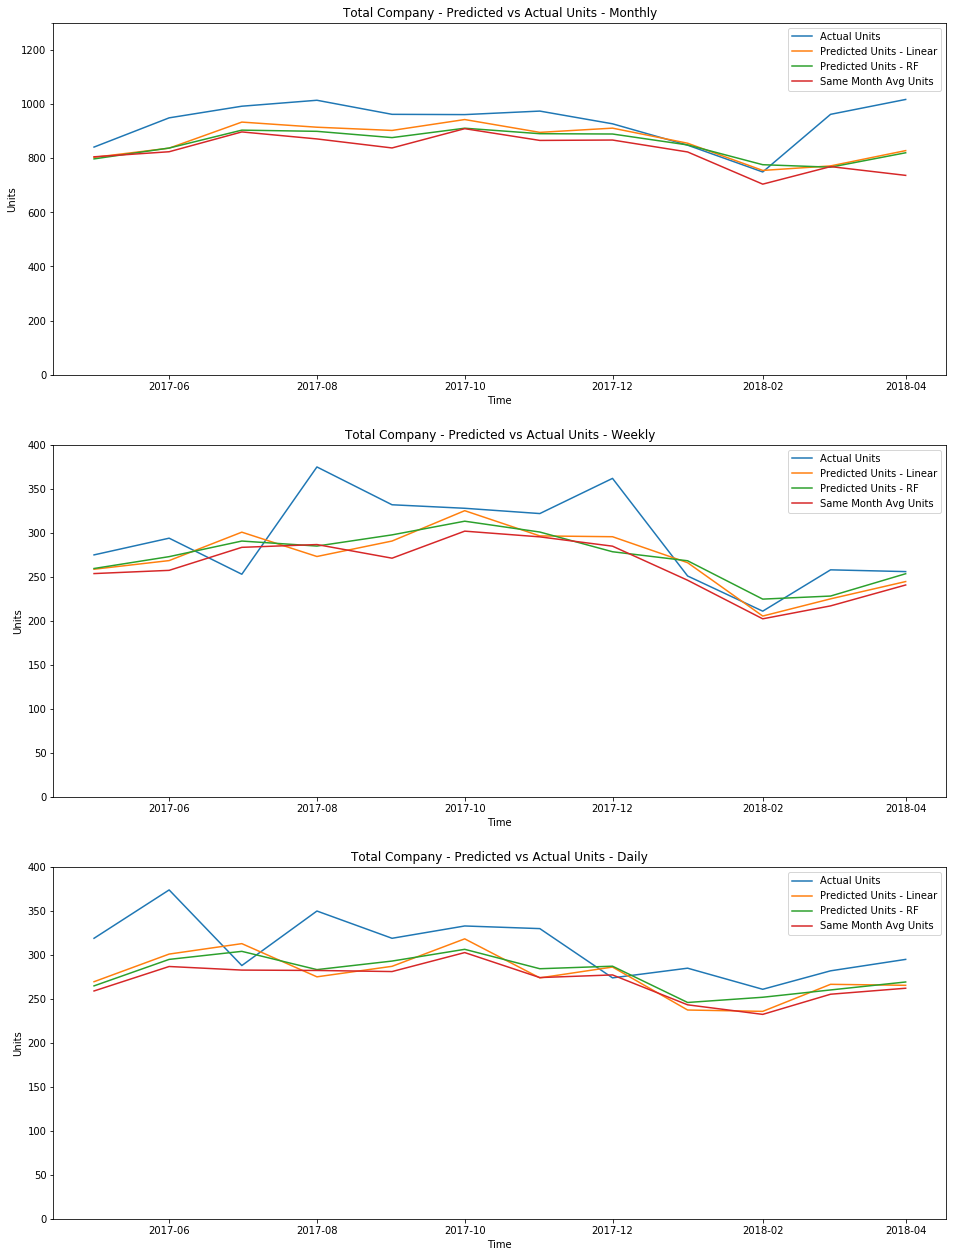

In [32]:
fig3 = plt.figure(figsize = (16,22))
ax1 = fig3.add_subplot(311)
ax2 = fig3.add_subplot(312)
ax3 = fig3.add_subplot(313)

ax1.plot(df_company_units_monthly['month'], df_company_units_monthly['units_rented'], label='Actual Units')
ax1.plot(df_company_units_monthly['month'], df_company_units_monthly['units_rented_pred_Linear'], label='Predicted Units - Linear')
ax1.plot(df_company_units_monthly['month'], df_company_units_monthly['units_rented_pred_Random Forest'], label='Predicted Units - RF')
ax1.plot(df_company_units_monthly['month'], df_company_units_monthly['same_month_avg_units_rented'], label='Same Month Avg Units')
ax1.set_xlabel('Time')
ax1.set_ylabel('Units')
ax1.set_title('Total Company - Predicted vs Actual Units - Monthly')
ax1.set_yticks([0, 1300], True)
ax1.legend();

ax2.plot(df_company_units_weekly['month'], df_company_units_weekly['units_rented'], label='Actual Units')
ax2.plot(df_company_units_weekly['month'], df_company_units_weekly['units_rented_pred_Linear'], label='Predicted Units - Linear')
ax2.plot(df_company_units_weekly['month'], df_company_units_weekly['units_rented_pred_Random Forest'], label='Predicted Units - RF')
ax2.plot(df_company_units_weekly['month'], df_company_units_weekly['same_month_avg_units_rented'], label='Same Month Avg Units')
ax2.set_xlabel('Time')
ax2.set_ylabel('Units')
ax2.set_title('Total Company - Predicted vs Actual Units - Weekly')
ax2.set_yticks([0, 400], True)
ax2.legend();

ax3.plot(df_company_units_daily['month'], df_company_units_daily['units_rented'], label='Actual Units')
ax3.plot(df_company_units_daily['month'], df_company_units_daily['units_rented_pred_Linear'], label='Predicted Units - Linear')
ax3.plot(df_company_units_daily['month'], df_company_units_daily['units_rented_pred_Random Forest'], label='Predicted Units - RF')
ax3.plot(df_company_units_daily['month'], df_company_units_daily['same_month_avg_units_rented'], label='Same Month Avg Units')
ax3.set_xlabel('Time')
ax3.set_ylabel('Units')
ax3.set_title('Total Company - Predicted vs Actual Units - Daily')
ax3.set_yticks([0, 400], True)
ax3.legend()
plt.savefig('../imgs/pred_v_acts_time.png');

In [33]:
df_20_220_units = df_agg_test.loc[df_agg_test['product_type_20-220'] == 1,:]
df_20_220_units_monthly = df_20_220_units.loc[df_20_220_units['rental_type_monthly'] == 1, :]
df_20_220_units_weekly = df_20_220_units.loc[df_20_220_units['rental_type_weekly'] == 1, :]
df_20_220_units_daily = df_20_220_units.loc[df_20_220_units['rental_type_daily'] == 1, :]
df_20_220_units.head()

,month,rental_revenue,total_days_rented,units_rented,avg_price_per_day,prior_month_rental_revenue,prior_month_total_days_rented,prior_month_units_rented,prior_month_avg_price_per_day,same_month_avg_units_rented,...,invoice_start_month_10,invoice_start_month_11,invoice_start_month_12,rental_type_daily,rental_type_monthly,rental_type_weekly,units_rented_pred_Linear,units_rented_pred_Lasso,units_rented_pred_Random Forest,units_rented_pred_Gradient Boosting
4440,2017-05-01,9369.0,330.000,46,28.390909,11233.0,402.000,51.0,27.942786,40.50,...,0,0,0,0,0,1,43.032748,43.694962,46.360344,42.596972
4441,2017-05-01,66380.0,5343.912,190,12.421612,67256.0,5569.956,197.0,12.074781,177.50,...,0,0,0,0,1,0,186.827012,183.836714,182.761147,184.967272
4442,2017-05-01,7536.0,72.000,53,104.666667,5050.0,53.000,42.0,95.283019,40.25,...,0,0,0,1,0,0,40.967637,40.657475,39.697878,37.975564
4521,2017-06-01,68989.0,5693.912,200,12.116274,66380.0,5343.912,190.0,12.421612,181.50,...,0,0,0,0,1,0,186.020372,184.360524,183.092675,183.508040
4522,2017-06-01,7237.0,78.000,57,92.782051,7536.0,72.000,53.0,104.666667,36.50,...,0,0,0,1,0,0,39.741075,41.502262,39.540815,40.738963


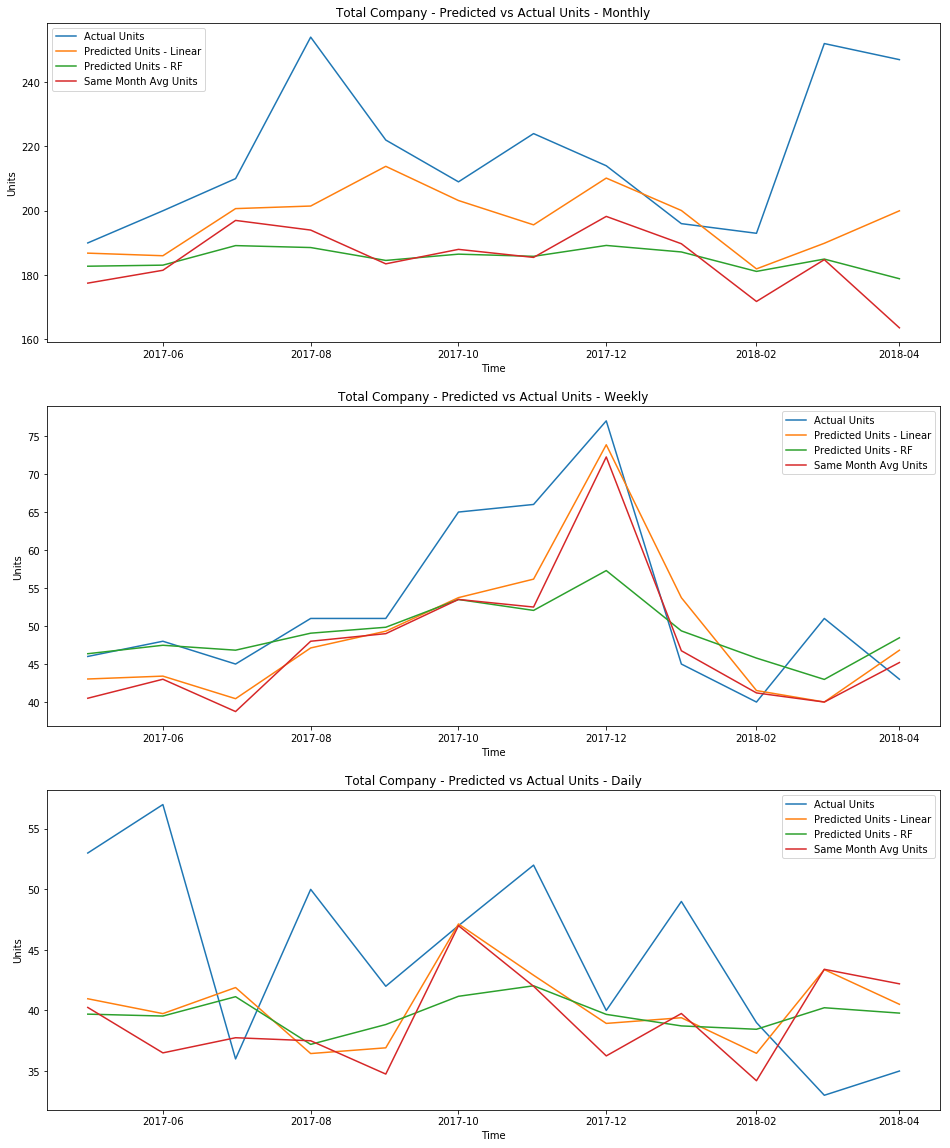

In [34]:
fig3 = plt.figure(figsize = (16,20))
ax1 = fig3.add_subplot(311)
ax2 = fig3.add_subplot(312)
ax3 = fig3.add_subplot(313)

ax1.plot(df_20_220_units_monthly['month'], df_20_220_units_monthly['units_rented'], label='Actual Units')
ax1.plot(df_20_220_units_monthly['month'], df_20_220_units_monthly['units_rented_pred_Linear'], label='Predicted Units - Linear')
ax1.plot(df_20_220_units_monthly['month'], df_20_220_units_monthly['units_rented_pred_Random Forest'], label='Predicted Units - RF')
ax1.plot(df_20_220_units_monthly['month'], df_20_220_units_monthly['same_month_avg_units_rented'], label='Same Month Avg Units')
ax1.set_xlabel('Time')
ax1.set_ylabel('Units')
ax1.set_title('Total Company - Predicted vs Actual Units - Monthly')
ax1.legend();

ax2.plot(df_20_220_units_weekly['month'], df_20_220_units_weekly['units_rented'], label='Actual Units')
ax2.plot(df_20_220_units_weekly['month'], df_20_220_units_weekly['units_rented_pred_Linear'], label='Predicted Units - Linear')
ax2.plot(df_20_220_units_weekly['month'], df_20_220_units_weekly['units_rented_pred_Random Forest'], label='Predicted Units - RF')
ax2.plot(df_20_220_units_weekly['month'], df_20_220_units_weekly['same_month_avg_units_rented'], label='Same Month Avg Units')
ax2.set_xlabel('Time')
ax2.set_ylabel('Units')
ax2.set_title('Total Company - Predicted vs Actual Units - Weekly')
ax2.legend();

ax3.plot(df_20_220_units_daily['month'], df_20_220_units_daily['units_rented'], label='Actual Units')
ax3.plot(df_20_220_units_daily['month'], df_20_220_units_daily['units_rented_pred_Linear'], label='Predicted Units - Linear')
ax3.plot(df_20_220_units_daily['month'], df_20_220_units_daily['units_rented_pred_Random Forest'], label='Predicted Units - RF')
ax3.plot(df_20_220_units_daily['month'], df_20_220_units_daily['same_month_avg_units_rented'], label='Same Month Avg Units')
ax3.set_xlabel('Time')
ax3.set_ylabel('Units')
ax3.set_title('Total Company - Predicted vs Actual Units - Daily')
ax3.legend()
plt.savefig('../imgs/pred_v_actuals_time_cat20220.png');

In [36]:
df_agg_test.loc[:, 'residuals_rf'] = df_agg_test['units_rented'] - df_agg_test['units_rented_pred_Random Forest']

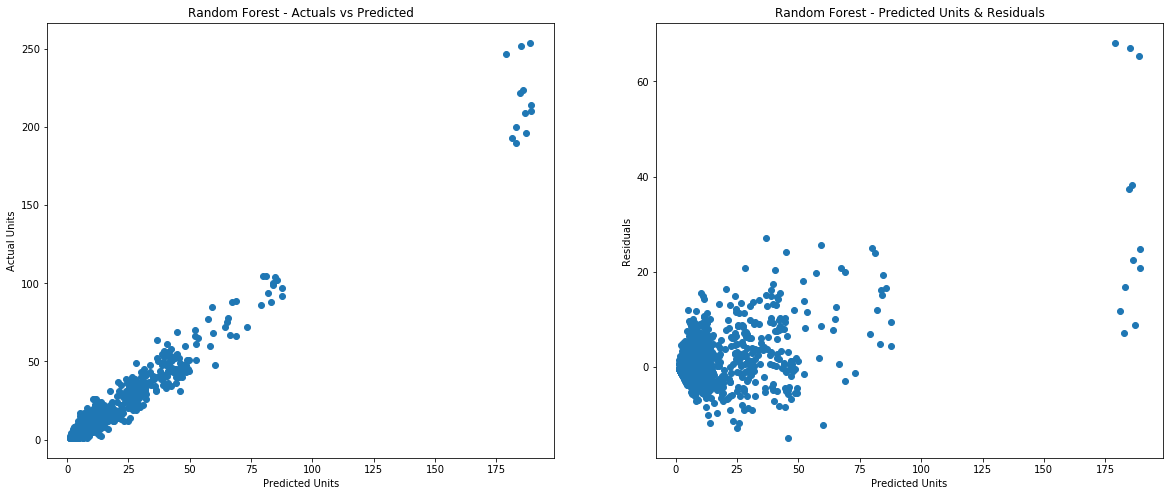

In [37]:
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(121)
ax1.scatter(df_agg_test['units_rented_pred_Random Forest'], df_agg_test['units_rented'])
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Actual Units')
ax1.set_title('Random Forest - Actuals vs Predicted')

ax2 = fig.add_subplot(122)
ax2.scatter(df_agg_test['units_rented_pred_Random Forest'], df_agg_test['residuals_rf'])
ax2.set_xlabel('Predicted Units')
ax2.set_ylabel('Residuals')
ax2.set_title('Random Forest - Predicted Units & Residuals')
plt.savefig('../imgs/random_forest_residuals.png');

In [38]:
df_agg_test.loc[:, 'residuals_linear'] = df_agg_test['units_rented'] - df_agg_test['units_rented_pred_Linear']

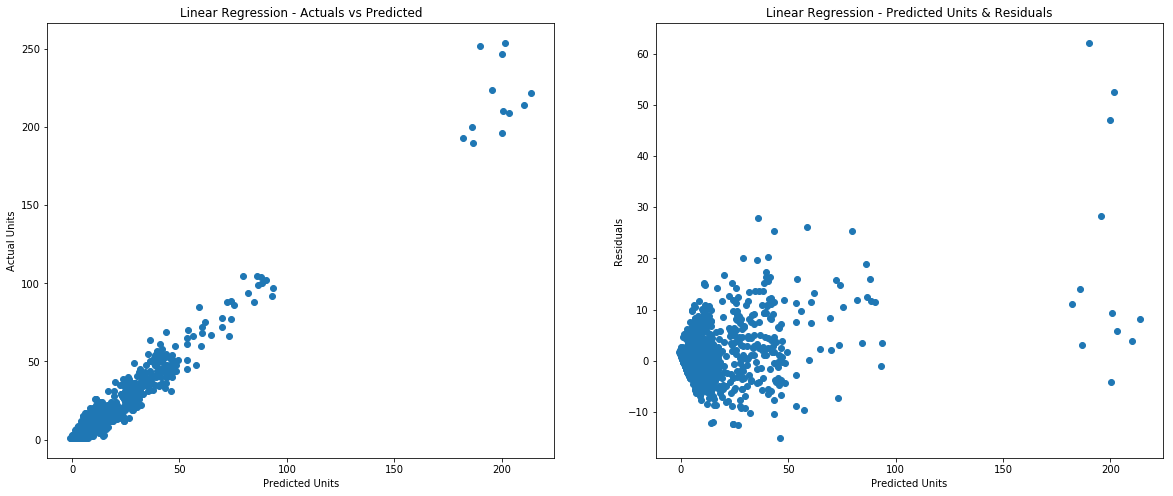

In [41]:
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(121)
ax1.scatter(df_agg_test['units_rented_pred_Linear'], df_agg_test['units_rented'])
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Actual Units')
ax1.set_title('Linear Regression - Actuals vs Predicted')

ax2 = fig.add_subplot(122)
ax2.scatter(df_agg_test['units_rented_pred_Linear'], df_agg_test['residuals_linear'])
ax2.set_xlabel('Predicted Units')
ax2.set_ylabel('Residuals')
ax2.set_title('Linear Regression - Predicted Units & Residuals')
plt.savefig('../imgs/linear_residuals.png');

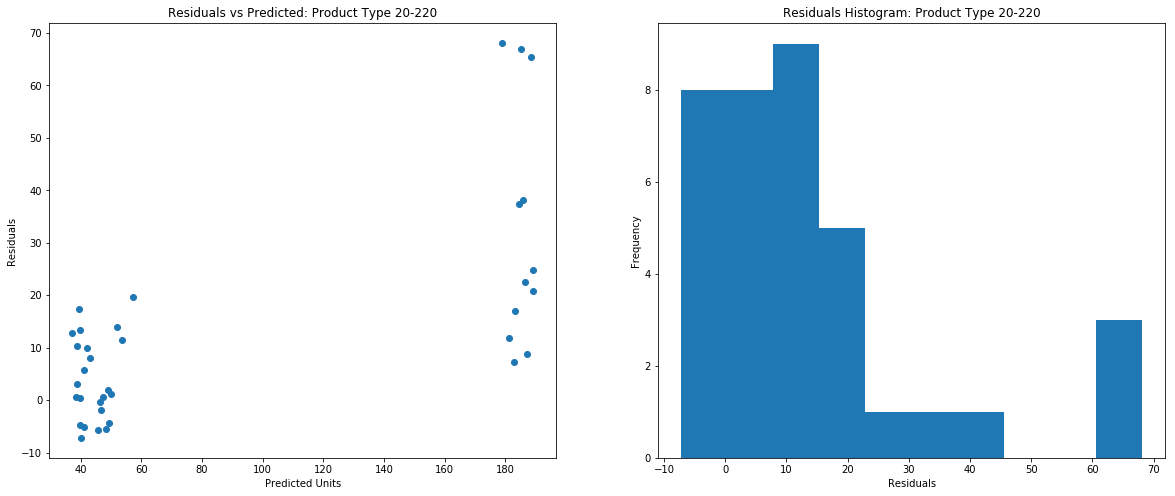

In [40]:
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(121)
ax1.scatter(df_agg_test.loc[df_agg_test['product_type_20-220'] == 1, 'units_rented_pred_Random Forest'], df_agg_test.loc[df_agg_test['product_type_20-220'] == 1, 'residuals_rf'])
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted: Product Type 20-220')

ax2 = fig.add_subplot(122)
ax2.hist(df_agg_test.loc[df_agg_test['product_type_20-220'] == 1, 'residuals_rf'], bins=10)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Residuals Histogram: Product Type 20-220');